In [73]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
import os
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc

In [74]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

nch = 0.85
ndisc = 0.95
ninv = 0.92
prgr = 1.25
prrw = 0.65
State
    x0 : SOC(t) - ndisc*u2/ninv - ndisc*u3/ninv + u4/ninv
    x1 : Cgr + prgr * Egr
    x2 : Cpv + prrw*(Epv.l + Echa)
    x3 : Cbat + prrw * (Edisc + Eop + Echa)
    x4 : Cl + prrw * Epv.l + prgr*Egr + prrw*Edisc
    
Input   
    u0 : Epv.l
    u1 : Egr
    u2 : Edisc
    u3 : Eop
    u4 : Echa

Output
    y0 : C1 + prrw*Epv.l
    y1 : C2 + prgr*Egr
    y2 : C3 + prrw*Edisc
    y3 : C4 + prrw*Eop
    y4 : C5 + prrw*Echa

In [75]:
pv_ext= model.set_variable(var_type='_tvp', var_name='pv_ext')
ld_ext = model.set_variable(var_type='_tvp', var_name='ld_ext')
ac_ext = model.set_variable(var_type='_tvp', var_name='ac_ext')
ad_ext = model.set_variable(var_type='_tvp', var_name='ad_ext')

In [76]:
# States struct (optimization variables):
# cha_s = model.set_variable('_x',  'cha_s')
# dis_s = model.set_variable('_x',  'dis_s')
grd_s = model.set_variable('_x',  'grd_s')
bat_s = model.set_variable('_x',  'bat_s')


In [77]:
# Input struct (optimization variables):
charge = model.set_variable('_u',  'charge')











In [78]:
BT_CAP = 5.
BT_MAX = 0.95
BT_MIN = 0.10

# model.set_rhs('pv_s', pv_ext)
# model.set_rhs('ld_s', ld_ext)
# model.set_rhs('cha_s', charge * (ac_ext))
# model.set_rhs('dis_s', charge * (ad_ext))
# if pv_ext - ld_ext > 0:
#     charging = max(0, pv_ext - ld_ext)  # Charging power
#     charge = min(BT_CAP*BT_MAX - bat_s, charging)
# else:
#     charging = min(max(bat_s-T_CAP*BT_MIN, 0), max(0, ld_ext - pv_ext)) # discharing power
#     charge = -charging # Update battery status
    
# model.set_rhs('grd_s', ld_ext -pv_ext - charge)
# model.set_rhs('bat_s', bat_s + charge)

model.set_rhs('grd_s', -ac_ext + ad_ext + charge)
model.set_rhs('bat_s', bat_s + charge)


In [79]:
# Build the model
model.setup()

In [80]:
mpc = do_mpc.controller.MPC(model)

In [81]:
n_horizon = 7

setup_mpc = {
    'n_robust': 0,
    'n_horizon': n_horizon,
    't_step': 1,
    'state_discretization': 'discrete',
    'store_full_solution':True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

In [82]:
import numpy as np 
import pandas as pd

TS = 48 # Time steps

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df = df/1000.
df_date = df.index
df.head()

customers = sorted(df.columns.levels[0])
data_test = df[10][['GG', 'GC']]
load = data_test['GC'].to_numpy()
pvgn = data_test['GG'].to_numpy()


In [83]:
import numpy as np 

# load = np.array([0.5, 1.7, 0.4, 0.9, 2.2, 5.7, 6.9, 4.7, 1.5, 4.2, 1.3, 4.5, 1.0, 0.9, 0.8, 4.3, 6.9, 3.0, 2.7, 8.4, 3.6, 3.1, 3.0, 0.5])
# pvgn = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 1.0, 2.0, 3.0, 3.7, 4.1, 4.2, 3.8, 3.5, 2.7, 1.9, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
achg = pvgn - load
achg = np.where(achg<0, 0, achg)
adch = load - pvgn
adch = np.where(adch<0, 0, adch)

mpc_tvp_template = mpc.get_tvp_template()

def mpc_tvp_fun(t_now): 
        ind = int(t_now/setup_mpc['t_step'])
        for k in range(n_horizon+1):                
                mpc_tvp_template['_tvp',k,'pv_ext'] = pvgn[(ind +k) % len(load)]
                mpc_tvp_template['_tvp',k,'ld_ext'] = load[(ind +k) % len(load)]
                mpc_tvp_template['_tvp',k,'ac_ext'] = achg[(ind +k) % len(load)]
                mpc_tvp_template['_tvp',k,'ad_ext'] = adch[(ind +k) % len(load)]

        return mpc_tvp_template

mpc.set_tvp_fun(mpc_tvp_fun)



In [84]:
mterm = model.x['grd_s']**2#+ model.u['discharge']# terminal cost
lterm = mterm # 0*(model.tvp['ld_ext'] - model.tvp['pv_ext'] + model.u['charge'])**2
 # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(charge=0.0) # input penalty

In [85]:
# mpc.set_nl_cons(expr_name='bat_s_limit',expr=(-ld_ext + pv_ext),ub=0,soft_constraint=False)
# mpc.set_nl_cons(expr_name='dis_s_limit',expr=(-bat_s - charge),ub=0,soft_constraint=False)
mpc.set_nl_cons(expr_name='chg_s_limit',expr=(charge - ac_ext),ub=0,soft_constraint=False)
# mpc.set_nl_cons(expr_name='dchg_s_limit',expr=(discharge - ad_ext),ub=0,soft_constraint=False)

# lower bounds of the states
# mpc.bounds['lower','_x','cha_s'] = 0.0
# mpc.bounds['lower','_x','dis_s'] = 0.0
# mpc.bounds['lower','_x','grd_s'] = 0.0
# upper bounds of the states
mpc.bounds['lower','_x','bat_s'] = BT_CAP*0.10 #pv_s
mpc.bounds['upper','_x','bat_s'] = BT_CAP*0.95 #pv_s

mpc.bounds['lower','_u','charge'] = -13.0
mpc.bounds['upper','_u','charge'] = +13.0

# mpc.bounds['lower','_u','discharge'] = 0.0
# mpc.bounds['upper','_u','discharge'] = 1.0

mpc.setup()


In [86]:
estimator = do_mpc.estimator.StateFeedback(model)

In [87]:
simulator = do_mpc.simulator.Simulator(model)

tvp_template = simulator.get_tvp_template()

def tvp_fun(t_now):
        ind = int(t_now/setup_mpc['t_step'])
        tvp_template['pv_ext'] = pvgn[ind % len(load)]
        tvp_template['ld_ext'] = load[ind % len(load)]
        tvp_template['ac_ext'] = achg[ind % len(load)]
        tvp_template['ad_ext'] = adch[ind % len(load)]

        return tvp_template

simulator.set_tvp_fun(tvp_fun)

In [88]:
simulator.set_param(t_step = 1)
simulator.setup()



In [89]:
x0 = np.array([0, BT_CAP*0.10])

mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()

In [90]:
%%capture
for k in range(len(load)):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [91]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 14

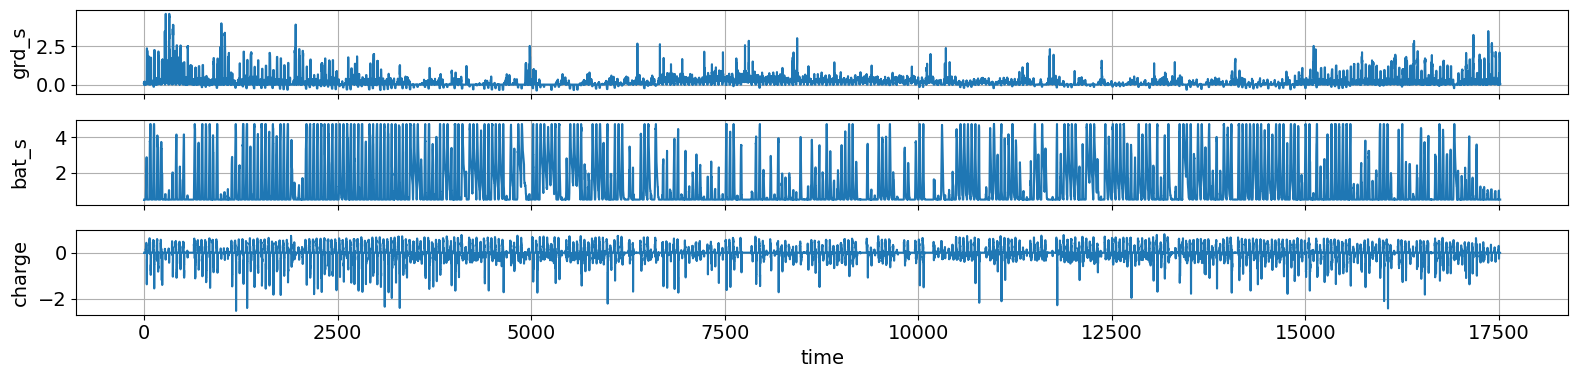

In [92]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data, figsize=(16,4))
graphics.plot_results()
graphics.reset_axes()
plt.show()

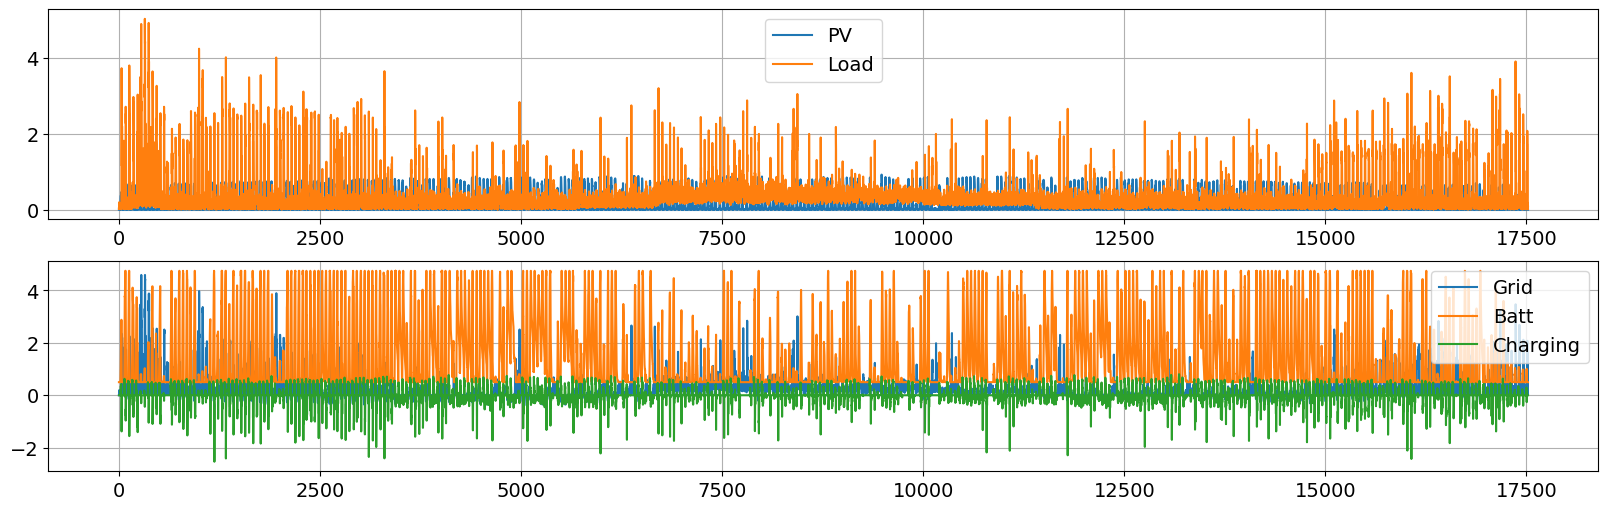

In [93]:
plt.figure(figsize=(20,6))
plt.subplot(2, 1, 1)
inputs = mpc.data['_tvp']
plt.plot(inputs[:,0], label='PV')#, drawstyle="steps-post")
plt.plot(inputs[:,1], label='Load')#, drawstyle="steps-post")
plt.legend()

plt.subplot(2, 1, 2)
states = mpc.data['_x']
plt.plot(states[:,0], label='Grid')#, drawstyle="steps-post")
plt.plot(states[:,1], label='Batt')#, drawstyle="steps-post")
charging = mpc.data['_u']
plt.plot(charging[:,0], label='Charging')#, drawstyle="steps-post")
plt.legend()
plt.show()

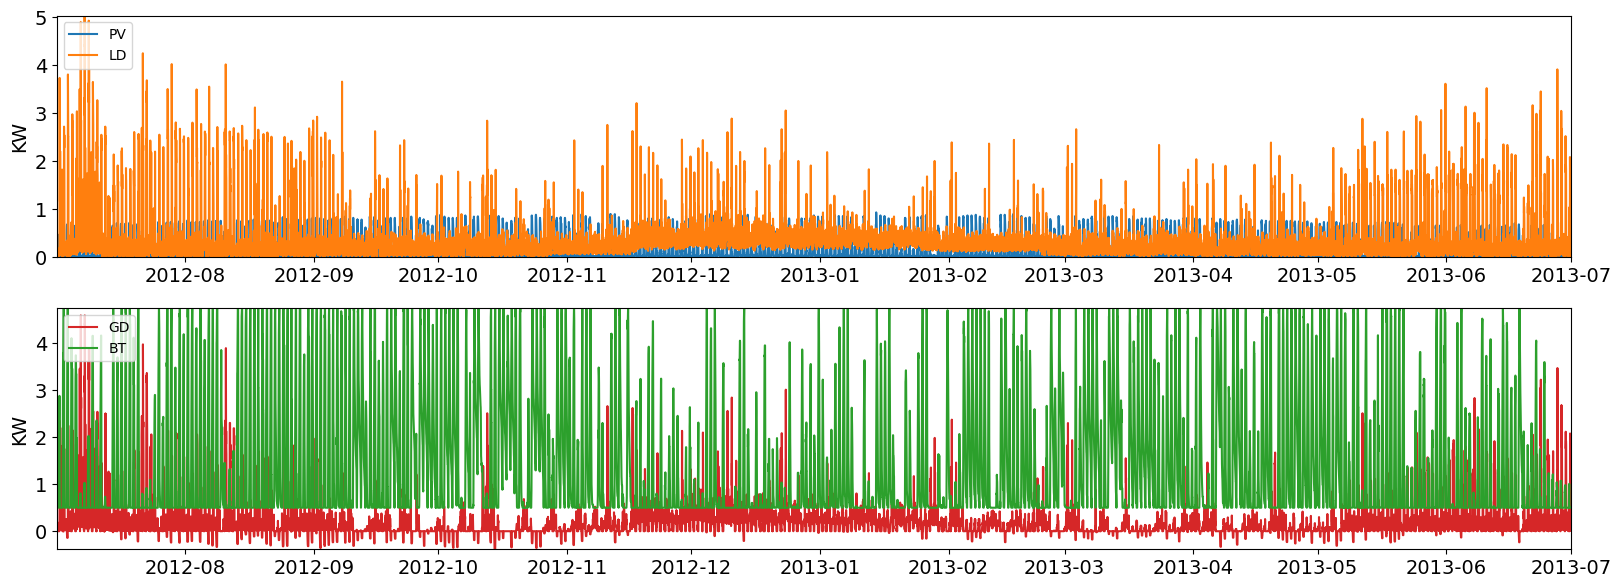

In [94]:
ipv = inputs[:,0]
ild = inputs[:,1]
aac = charging[:,0]
sgd = states[:,0]
sbt = states[:,1]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
plt.rcParams["font.size"] = "10"
fig.tight_layout()

axes[0].plot(df_date.values, ipv, label='PV', color='#1f77b4')
axes[0].plot(df_date.values, ild, label='LD', color='#ff7f0e')
axes[0].legend(loc='upper left')
axes[0].set_ylabel('KW')
axes[0].grid(False)
axes[0].margins(0,0)

axes[1].plot(df_date.values, sgd, label='GD', color='#d62728')
axes[1].plot(df_date.values, sbt, label='BT', color='#2ca02c')
axes[1].legend(loc='upper left')
axes[1].set_ylabel('KW')
axes[1].grid(False)
axes[1].margins(0,0)


In [95]:
Egen = ipv.sum()
print(Egen, 'KW')
Eload = ild.sum()
print(Eload, 'KW')
GDimport = sum(v for v in sgd if v > 0) 
print(GDimport)
GDexport = sum(v for v in sgd if v < 0) 
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

2433.396 KW
5719.433999999999 KW
3525.270012044632
-239.312012021447
SC : 0.901655130516592
SS : 0.38361907628946385


(8000.0, 8336.0)

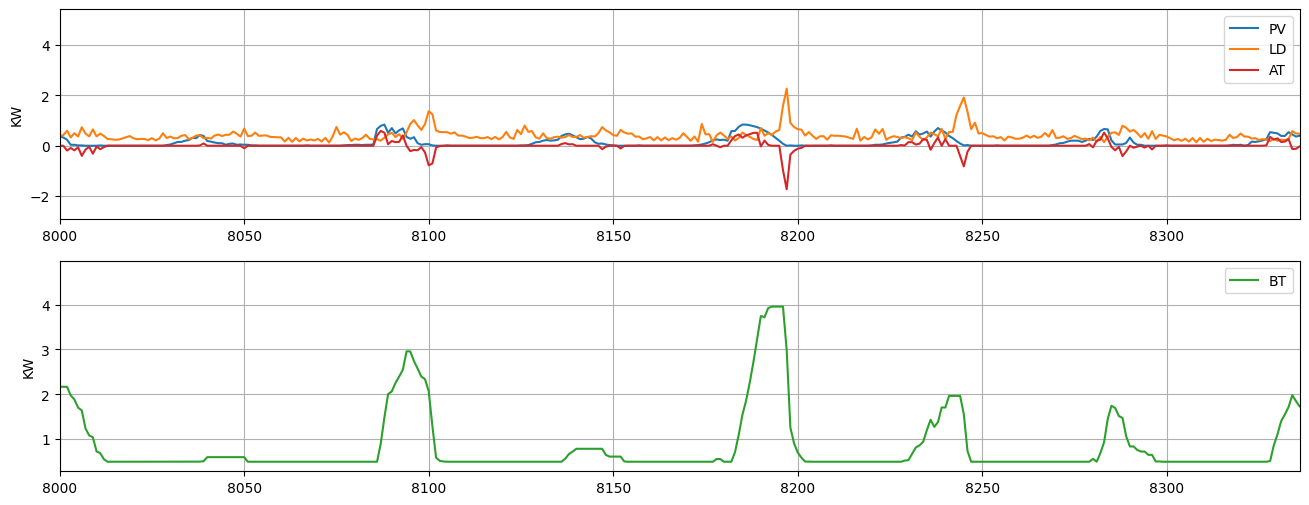

In [96]:
SP = 8000
EP = SP + 48*7
ipv = inputs[:,0]
ild = inputs[:,1]
aac = charging[:,0]
sgd = states[:,0]
sbt = states[:,1]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
axes[0].plot(ipv, label='PV', color='#1f77b4')
axes[0].plot(ild, label='LD', color='#ff7f0e')
axes[0].plot(aac, label='AT', color='#d62728')
axes[0].legend(loc='upper right')
axes[0].set_ylabel('KW')
axes[0].set_xlim(SP, EP)

axes[1].plot(sbt, label='BT', color='#2ca02c')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('KW')
axes[1].set_xlim(SP, EP)